In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling
import cufflinks as cf
import plotly.offline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
pd.set_option('display.max_columns', 38)

DATA_DIR = "/home/gangda/workspace/ds-richter/data"

X = pd.read_csv(DATA_DIR + '/train_values.csv', index_col='building_id')
y = pd.read_csv(DATA_DIR + '/train_labels.csv', index_col='building_id')
X_test = pd.read_csv(DATA_DIR + '/test_values.csv', index_col='building_id')

cat_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type',
            'roof_type',
            'ground_floor_type', 'other_floor_type', 'position',
            'plan_configuration', 'legal_ownership_status', 'count_floors_pre_eq', 'has_superstructure_adobe_mud',
            'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
            'has_superstructure_cement_mortar_stone',
            'has_superstructure_mud_mortar_brick',
            'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
            'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
            'has_superstructure_rc_engineered', 'has_superstructure_other',
            'legal_ownership_status', 'has_secondary_use',
            'has_secondary_use_agriculture', 'has_secondary_use_hotel',
            'has_secondary_use_rental', 'has_secondary_use_institution',
            'has_secondary_use_school', 'has_secondary_use_industry',
            'has_secondary_use_health_post', 'has_secondary_use_gov_office',
            'has_secondary_use_use_police', 'has_secondary_use_other']

In [41]:
df_train = X.join(y)
df_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,...,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,...,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,...,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,...,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,...,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,...,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,...,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,...,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,...,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [50]:
geo_group = df_train.groupby('geo_level_3_id')['damage_grade']
des = geo_group.describe()
des

,count,mean,std,min,25%,50%,75%,max
geo_level_3_id,,,,,,,,
0,2.0,3.000000,0.000000,3.0,3.00,3.0,3.0,3.0
1,6.0,2.500000,0.836660,1.0,2.25,3.0,3.0,3.0
3,9.0,1.888889,0.333333,1.0,2.00,2.0,2.0,2.0
5,14.0,1.142857,0.363137,1.0,1.00,1.0,1.0,2.0
6,21.0,2.523810,0.679636,1.0,2.00,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...
12562,3.0,2.000000,0.000000,2.0,2.00,2.0,2.0,2.0
12563,24.0,2.041667,0.204124,2.0,2.00,2.0,2.0,3.0
12564,6.0,2.000000,0.000000,2.0,2.00,2.0,2.0,2.0


In [383]:
df_mask = ((des['count'] > 5) & (des['std'] <= 0))
df_mask = geo_group.mean()[df_mask]
df_mask = df_mask.round(0).astype(int)
df_mask

geo_level_3_id
14       2
17       2
37       2
57       2
88       3
        ..
12500    3
12505    2
12512    2
12526    2
12564    2
Name: damage_grade, Length: 854, dtype: int64

In [384]:
from tqdm import tqdm

df_pred = pd.read_csv(DATA_DIR + '/submission/submission_7540.csv', index_col='building_id')
df = df_pred.join(X_test['geo_level_3_id'])

for index, row in tqdm(df_mask.iteritems(), total=df_mask.shape[0]):
    df['damage_grade'][df['geo_level_3_id'] == index] = row

df = df.drop('geo_level_3_id', axis=1)
df

100%|██████████| 854/854 [00:00<00:00, 1134.15it/s]


,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3
...,...
310028,2
663567,3
1049160,2


In [387]:
m = ((df - df_pred) > 0).to_numpy()
m.sum()

19

In [388]:
df.to_csv(DATA_DIR + '/submission/final_7540_{}.csv'.format('smooth_(5_0)_19'))
df

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3
...,...
310028,2
663567,3
1049160,2


---

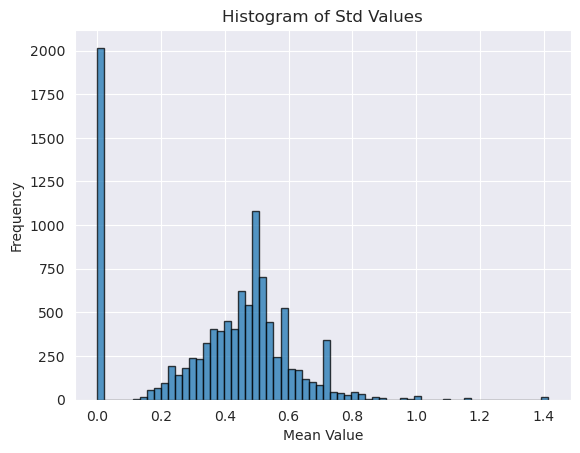

In [253]:
geo_mean = df_train.groupby('geo_level_3_id')['damage_grade'].std()

# Plot the histogram
plt.hist(geo_mean, bins='auto', alpha=0.75, edgecolor='black')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Histogram of Std Values')
plt.grid(True)
plt.show()

geo_level_3_id
0        0.000000
1        0.836660
3        0.333333
5        0.363137
6        0.679636
           ...   
12562    0.000000
12563    0.204124
12564    0.000000
12565    0.487950
12567         NaN
Name: damage_grade, Length: 11595, dtype: float64

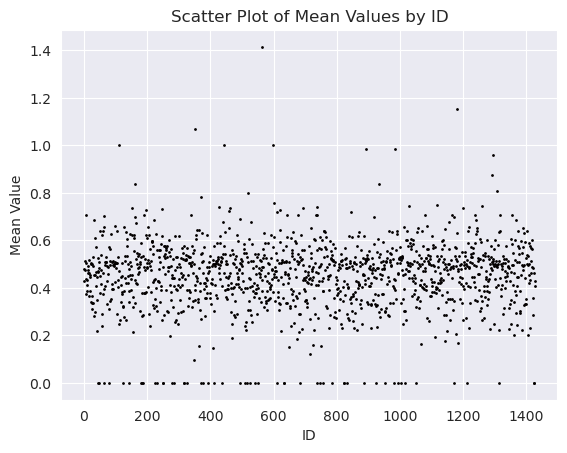

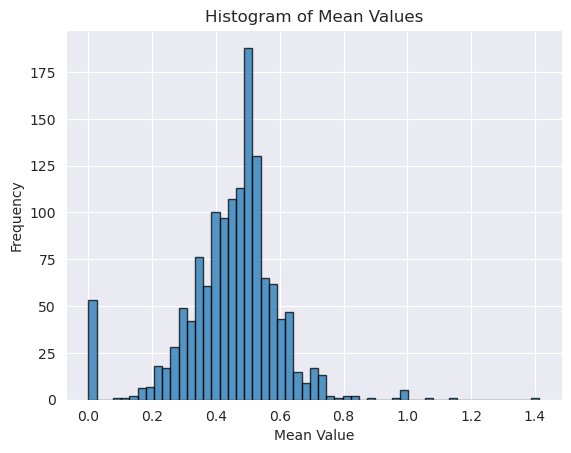

In [38]:
geo_mean = df_train.groupby('geo_level_2_id')['damage_grade'].std()

plt.scatter(geo_mean.index, geo_mean.values, c='red', marker='o', s=1, edgecolor='black')
plt.xlabel('ID')
plt.ylabel('Mean Value')
plt.title('Scatter Plot of Mean Values by ID')
plt.grid(True)
plt.show()

# Plot the histogram
plt.hist(geo_mean, bins='auto', alpha=0.75, edgecolor='black')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Values')
plt.grid(True)
plt.show()

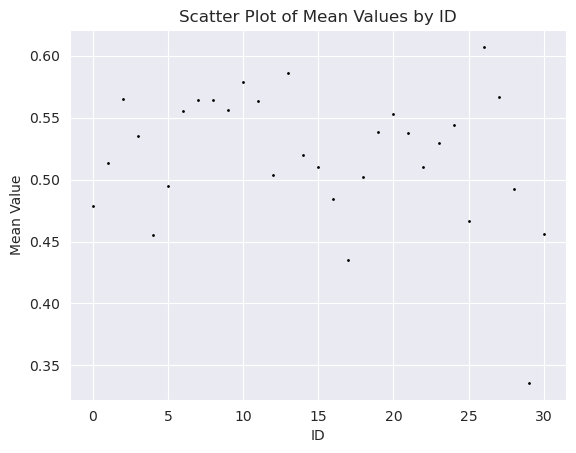

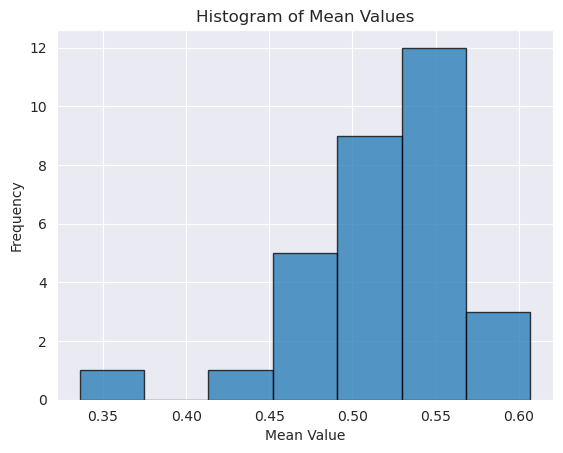

In [39]:
geo_mean = df_train.groupby('geo_level_1_id')['damage_grade'].std()

plt.scatter(geo_mean.index, geo_mean.values, c='red', marker='o', s=1, edgecolor='black')
plt.xlabel('ID')
plt.ylabel('Mean Value')
plt.title('Scatter Plot of Mean Values by ID')
plt.grid(True)
plt.show()

# Plot the histogram
plt.hist(geo_mean, bins='auto', alpha=0.75, edgecolor='black')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Values')
plt.grid(True)
plt.show()

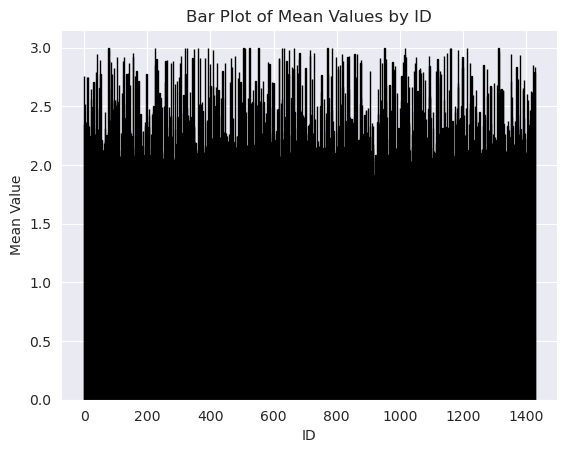

In [29]:
plt.bar(geo_mean.index, geo_mean.values, color='blue', edgecolor='black')
plt.xlabel('ID')
plt.ylabel('Mean Value')
plt.title('Bar Plot of Mean Values by ID')
plt.grid(True)
plt.show()